In [1]:
using PhotonPropagation
using StaticArrays
using PhysicsTools
using CairoMakie
using CSV
using Format
using DataFrames
using Base.Iterators
using LinearAlgebra
using JSON3
using Rotations
using Glob
buffer_cpu, buffer_gpu = make_hit_buffers();

## Axicone Simulation Study
Here we are comparing the ability to reconstruct the mean scattering angle with an Axicone and an LED.

In [1]:
# Monochromatic Spectrum @ 488nm
wavelength = 488f0
spectrum = Monochromatic(wavelength)
n_photons = Int64(1E10)
# Axicone placed at [0, 0, 0], pointing at [0, 0, 1]. Single delta emission with 1E11 photons. Emission angle 45° with 0.5° dispersion.
axi = AxiconeEmitter(SA_F32[0,0,0], SA_F32[0, 0, 1], 0f0, n_photons, deg2rad(45f0), deg2rad(0.0005f0))
# Isotropic emitter collimated to 60° opening angle (LED approximation).
led = CollimatedIsotropicEmitter(SA_F32[0,0,0], 0f0, n_photons, cos(deg2rad(60f0)))

# Detector consisting of two lines: One at xy=(0,0) and one at xy=(0,50). Modules every 50m in z.
detector = [POM(SA_F32[0f0, 0f0, Float32(zpos)], i) for (i, zpos) in enumerate([-150, -100, -50, 50, 100, 150])]
detector = vcat(detector, [POM(SA_F32[0f0, 50f0, Float32(zpos)], i+length(detector)) for (i, zpos) in enumerate([-150, -100, -50, 0, 50, 100, 150])]);

# Medium
medium = make_cascadia_medium_properties(Float32(0.99), 1f0, 1f0)

println("Absorpion length: $(absorption_length(wavelength, medium))")
println("Scattering length: $(scattering_length(wavelength, medium))")





UndefVarError: UndefVarError: `Monochromatic` not defined

### Emission Plots

In [2]:

initial_states_axicone = [PhotonPropagationCuda.initialize_photon_state(axi, medium, spectrum) for _ in 1:1000]
initial_states_led = [PhotonPropagationCuda.initialize_photon_state(led, medium, spectrum) for _ in 1:1000]
fig = Figure()
ax = Axis3(fig[1,1], aspect=(1,1,1), title="Emission Profile")
scatter!(ax, [state.direction for state in initial_states_led], color=(:orange, 0.7), label="LED")
scatter!(ax, [state.direction for state in initial_states_axicone], color=(:royalblue1, 0.7), label="Axicone")
zlims!(ax, -1, 1)
axislegend("Emitter")
fig

UndefVarError: UndefVarError: `PhotonPropagationCuda` not defined

### Run Simulations

In [3]:
# Simulate photons for different g (mean scattering angle)
gs = [0.9, 0.93, 0.95, 0.99]
#emitters = [:axicone, :led]
emitters = [:axicone]
hit_stats = []
seed = 1
for (g, emitter) in product(gs, emitters)
    medium = make_cascadia_medium_properties(Float32(g), 1f0, 1f0)

    source = emitter == :axicone ? axi : led

    setup = PhotonPropSetup([source], detector, medium, spectrum, seed, 1.)
    photons = propagate_photons(setup, buffer_cpu, buffer_gpu, 25, copy_output=true)
    hits = make_hits_from_photons(photons, setup)
    calc_pe_weight!(hits, setup)
    hits[!, :g] .= g
    hits[!, :emitter] .= emitter
    hits[!, :line_id] .= hits[:, :module_id] .÷ 7
    push!(hit_stats, hits)
end
hit_stats = reduce(vcat, hit_stats)
;

UndefVarError: UndefVarError: `axi` not defined

In [5]:
# Simulate photons for different scattering lengths
sca_lens = 0.9:0.05:1.1
emitters = [:axicone, :led]
hit_stats_sca = []
seed = 1
for (sca_len, emitter) in product(sca_lens, emitters)
    medium = make_cascadia_medium_properties(Float32(0.95), 1f0, Float32(sca_len))

    source = emitter == :axicone ? axi : led

    setup = PhotonPropSetup([source], detector, medium, spectrum, seed, 1.)
    photons = propagate_photons(setup, buffer_cpu, buffer_gpu, copy_output=true)
    hits = make_hits_from_photons(photons, setup)
    calc_pe_weight!(hits, setup)
    hits[!, :sca_len] .= sca_len
    hits[!, :emitter] .= emitter
    hits[!, :line_id] .= hits[:, :module_id] .< 7
    push!(hit_stats_sca, hits)
end
hit_stats_sca = reduce(vcat, hit_stats_sca);

### Plot results

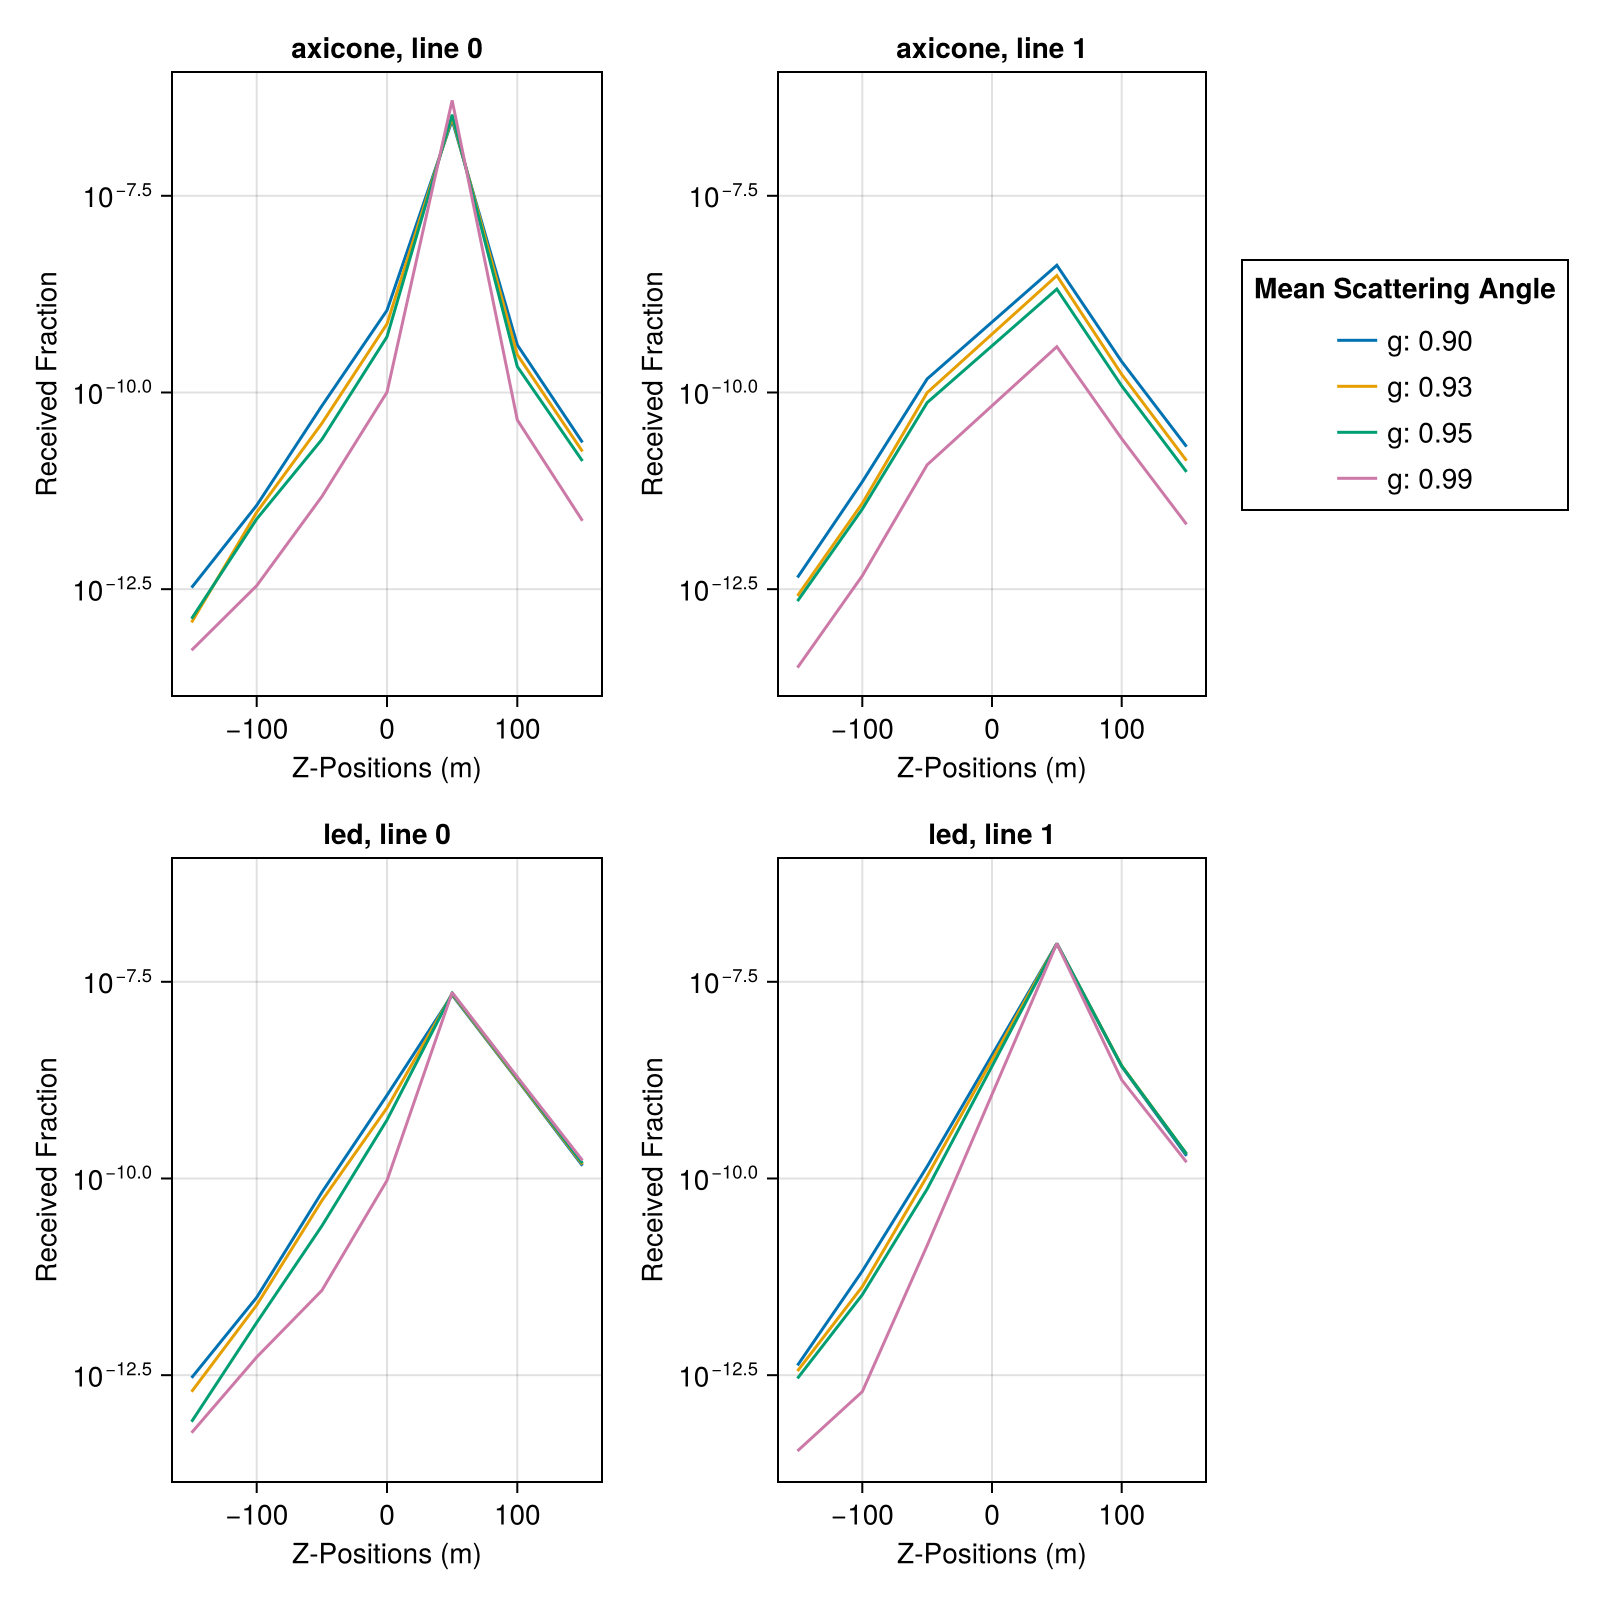

In [6]:
fig = Figure(size=(800, 800))
for (i, (emitter_name, em_group)) in enumerate(pairs(groupby(hit_stats, :emitter)))
    for (j, (line_id, line_group)) in enumerate(pairs(groupby(em_group, :line_id)))
        ax = Axis(fig[i, j], yscale=log10, xlabel="Z-Positions (m)", ylabel="Received Fraction", title="$(emitter_name[1]), line $(Int64(line_id[1]))")
        for (groupn, group) in pairs(groupby(line_group, :g))
            zpos_dict = Dict(mod.module_id => mod.shape.position[3] for mod in detector )
            total_hits = combine(groupby(group, :module_id), :total_weight => sum)

            total_hits = total_hits
            sort!(total_hits, :module_id)
            distances = [zpos_dict[mid] for mid in total_hits.module_id]
            lines!(ax, distances, total_hits.total_weight_sum ./ axi.photons, label=format("g: {:.2f}", groupn[1]))

        end
    end
end

linkaxes!([a for a in fig.content if a isa Axis]...)


Legend(fig[1, 3], fig.content[1], "Mean Scattering Angle")
fig

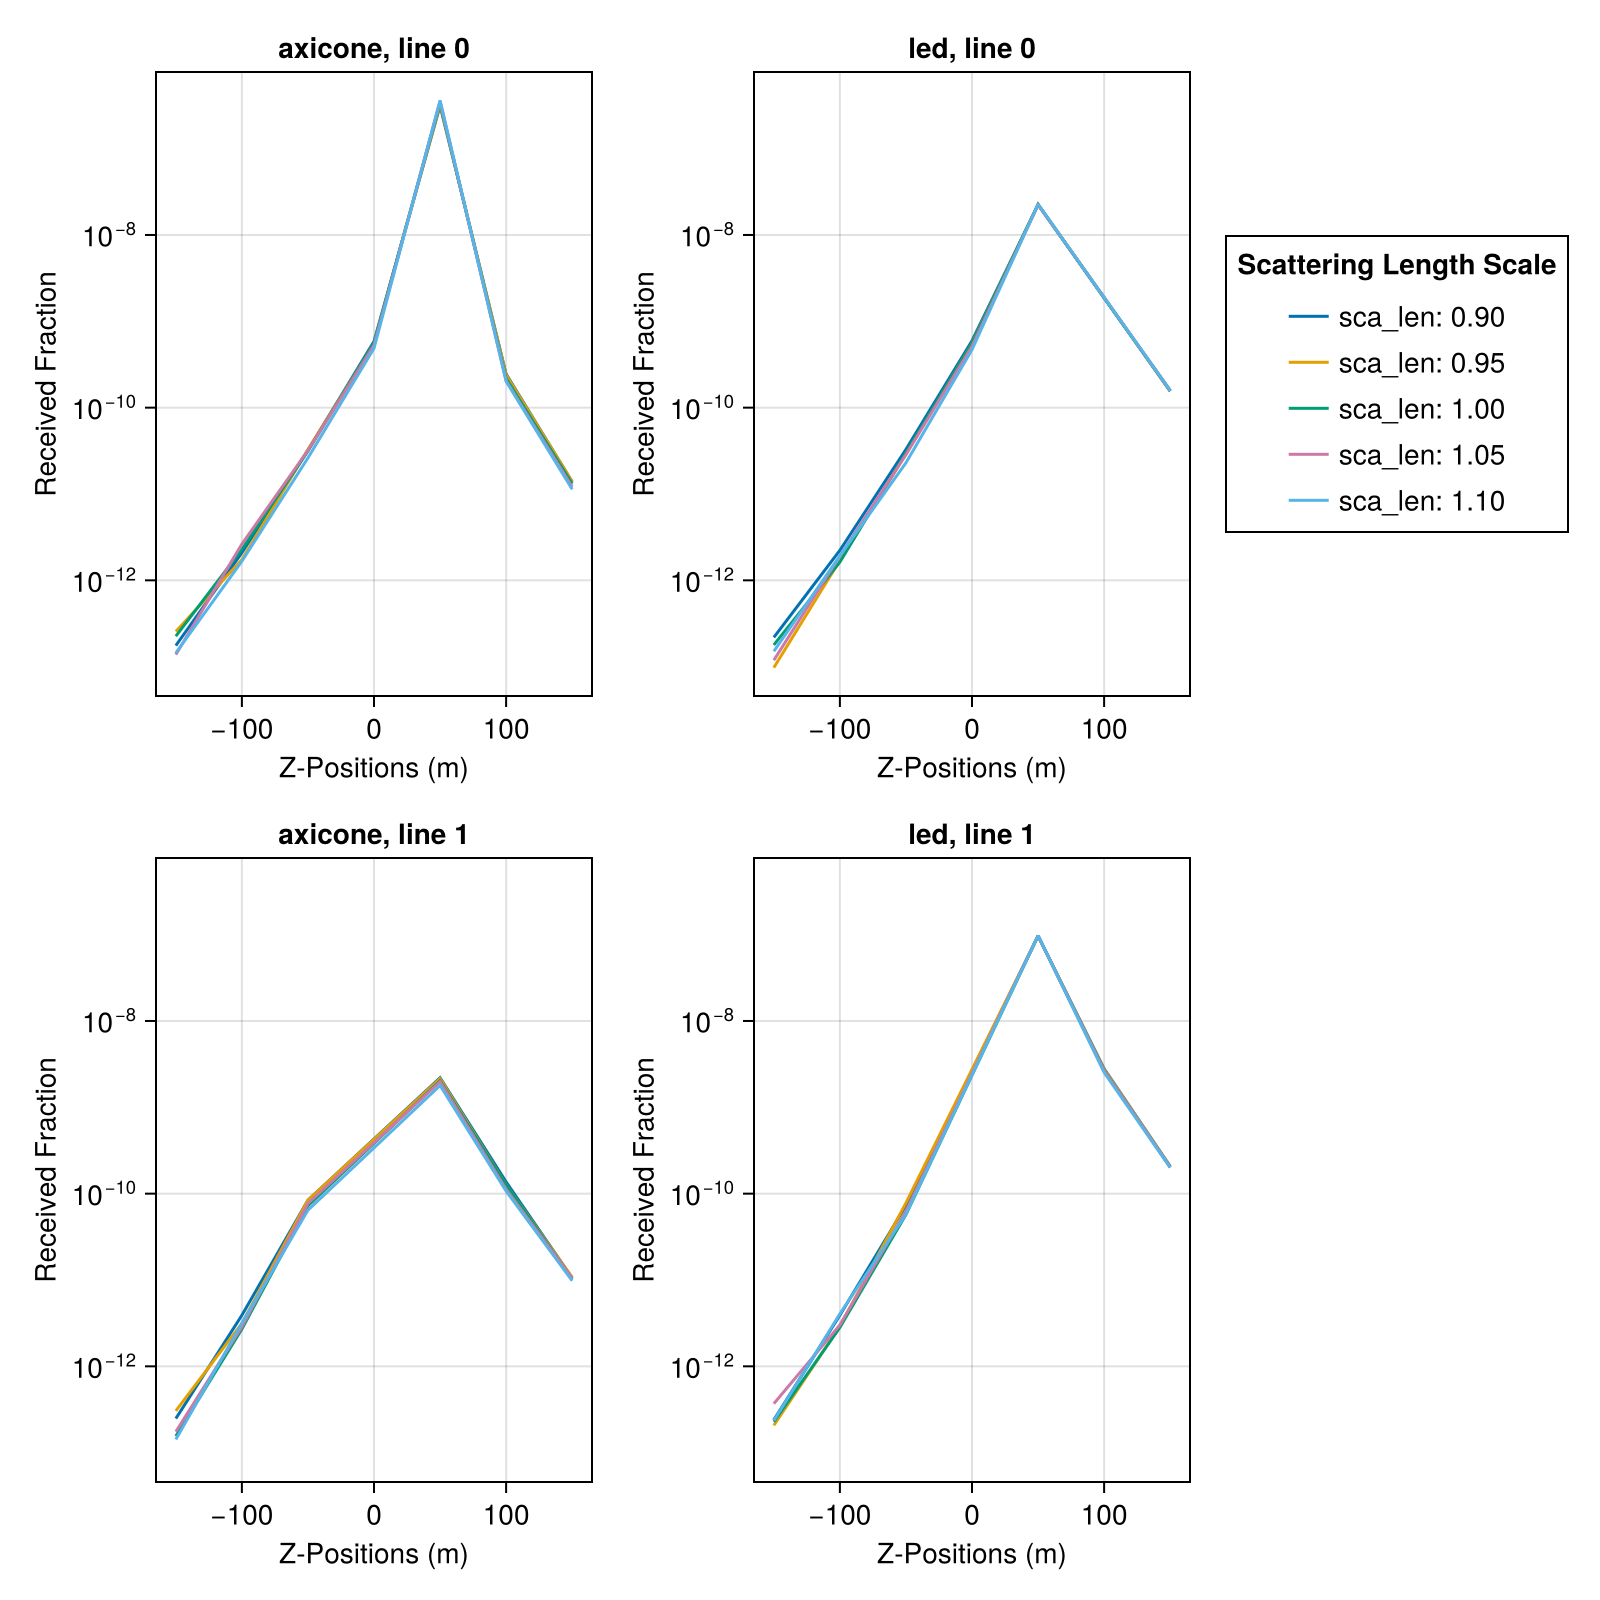

In [8]:
fig = Figure(size=(800, 800))
for (i, (emitter_name, em_group)) in enumerate(pairs(groupby(hit_stats_sca, :emitter)))
    for (j, (line_id, line_group)) in enumerate(pairs(groupby(em_group, :line_id)))
        ax = Axis(fig[j, i], yscale=log10, xlabel="Z-Positions (m)", ylabel="Received Fraction", title="$(emitter_name[1]), line $(Int64(line_id[1]))")
        for (groupn, group) in pairs(groupby(line_group, :sca_len))
            zpos_dict = Dict(mod.module_id => mod.shape.position[3] for mod in detector )
            total_hits = combine(groupby(group, :module_id), :total_weight => sum)

            total_hits = total_hits
            sort!(total_hits, :module_id)
            distances = [zpos_dict[mid] for mid in total_hits.module_id]


            lines!(ax, distances, total_hits.total_weight_sum ./ axi.photons, label=format("sca_len: {:.2f}", groupn[1]))

        end
    end
end


linkaxes!([a for a in fig.content if a isa Axis]...)


Legend(fig[1, 3], fig.content[1], "Scattering Length Scale")

fig

### Load pretorian simulation

In [6]:
hit_stats_pretorian = []
sim_files = glob("*simType_8_lightAngle_90*.dat", "/home/wecapstor3/capn/capn100h/pretorian/simulation_output/",)
for fname in sim_files
    open(fname, "r") do hdl
        det_info = JSON3.read(readline(hdl))
        sims = readlines(hdl)

        targets = POM[]
        open(det_info[:input_detectors]) do geomfile 
            modules = JSON3.read.(readlines(geomfile))
            for mod in modules
                target = POM(SVector{3, Float64}(mod[:position]), mod[:detectornr]+1)
                push!(targets, target)
            end
        end

        all_photons = []

        for sim in sims

            sim = Dict(JSON3.read(sim))
            @show sim

            direct_photons = DataFrame(sim[:direct])
            direct_photons[!, :total_weight] = direct_photons[!, :value]  .* det_info[:number_of_photons]

            hybrid_photons = DataFrame(sim[:hist])
            hybrid_photons[!, :total_weight] = hybrid_photons[!, :value]  .* det_info[:number_of_photons]

            photons = vcat(direct_photons, hybrid_photons)

            photons[!, :module_id] .= sim[:detectornr] +1
            photons[!, :wavelength] .= 488.
            photons[!, :position] .= copy.(photons[:, :position])
            photons[!, :direction] .= copy.(photons[:, :direction])

            push!(all_photons, photons)

        end
        photons = reduce(vcat, all_photons)
            
        hits = make_hits_from_photons(photons, targets, RotMatrix3(I))
            
        calc_pe_weight!(hits, targets)

        hits[!, :emitter] .= :axicone
        hits[!, :line_id] .= hits[:, :module_id] .÷ 7
        hits[!, :g] .= det_info[:scattering_ratio]
        hits[!, :n_total] .= det_info[:number_of_photons]
        push!(hit_stats_pretorian, hits)
    end
end
hit_stats_pretorian = reduce(vcat, hit_stats_pretorian);


In [5]:
fig = Figure(size=(800, 400))

colors = Makie.wong_colors()

for (i, (emitter_name, em_group)) in enumerate(pairs(groupby(hit_stats, :emitter)))
    for (j, (line_id, line_group)) in enumerate(pairs(groupby(em_group, :line_id)))
        line_group = sort(line_group, :g)
        ax = Axis(fig[i, j], yscale=log10, xlabel="Z-Positions (m)", ylabel="Received Fraction", title="$(emitter_name[1]), line $(Int64(line_id[1]))")
        for (gix, (groupn, group)) in enumerate(pairs(groupby(line_group, :g)))
            zpos_dict = Dict(mod.module_id => mod.shape.position[3] for mod in detector )

            total_hits = combine(groupby(group, :module_id), :total_weight => sum)

            total_hits = total_hits
            sort!(total_hits, :module_id)
            distances = [zpos_dict[mid] for mid in total_hits.module_id]
            lines!(ax, distances, total_hits.total_weight_sum ./ axi.photons, label=format("g: {:.2f}", groupn[1]), color=colors[gix])

        end
    end
end

hit_stats_pretorian[:, :relative_hits] = hit_stats_pretorian[:, :total_weight] ./ hit_stats_pretorian[:, :n_total]

for (i, (emitter_name, em_group)) in enumerate(pairs(groupby(hit_stats_pretorian, :emitter)))
    for (j, (line_id, line_group)) in enumerate(pairs(groupby(em_group, :line_id)))
        ax = fig[i, j]
        line_group = sort(line_group, :g)
        for (gix, (groupn, group)) in enumerate(pairs(groupby(line_group, :g)))
            zpos_dict = Dict(mod.module_id => mod.shape.position[3] for mod in detector )

             total_hits = combine(groupby(group, :module_id), :relative_hits => sum)

            total_hits = total_hits
            sort!(total_hits, :module_id)
            distances = [zpos_dict[mid] for mid in total_hits.module_id]
            lines!(ax, distances, total_hits.relative_hits_sum, linestyle=:dash, color=colors[gix])
        end
    end
end


linkaxes!([a for a in fig.content if a isa Axis]...)


Legend(fig[1, 3], fig.content[1], "Mean Scattering Angle")
fig

UndefVarError: UndefVarError: `hit_stats` not defined

In [42]:
colors